In [1]:
from sklearn.preprocessing import normalize as norm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random

from korgorusz.optimizers import Momentum
from korgorusz.layers import *
from korgorusz.activations import *
from korgorusz.utils import *

In [2]:
# !wget https://data.deepai.org/mnist.zip
# !unzip mnist.zip
x,y,x_test,y_test=mnist("./",["train-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz","t10k-images-idx3-ubyte.gz","t10k-labels-idx1-ubyte.gz"])

--2021-06-03 14:14:56--  https://data.deepai.org/mnist.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11597176 (11M) [application/x-zip-compressed]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  11.06M  13.5MB/s    in 0.8s    

2021-06-03 14:14:57 (13.5 MB/s) - ‘mnist.zip’ saved [11597176/11597176]

Archive:  mnist.zip
  inflating: train-labels-idx1-ubyte.gz  
  inflating: train-images-idx3-ubyte.gz  
  inflating: t10k-images-idx3-ubyte.gz  
  inflating: t10k-labels-idx1-ubyte.gz  


In [3]:
x.shape

(60000, 784)

In [4]:
np.random.seed(42)


x = norm(x)
y = one_hot(y, 10)
x, y = shuffle(x, y)

x_test = norm(x_test)
y_test = one_hot(y_test, 10)
x_test, y_test = shuffle(x_test, y_test)

x.shape,y.shape,x_test.shape,y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

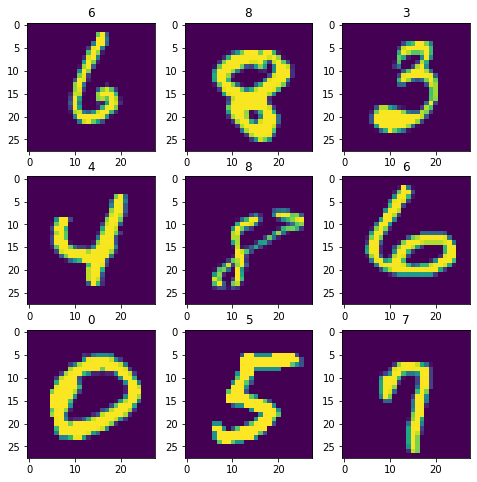

In [5]:
fig=plt.figure(figsize=(8,8))
col,rows=3,3
for i in range(1,col * rows + 1):
    j = random.randint(0,9999)
    fig.add_subplot(rows,col,i)
    plt.imshow(x_test[j].reshape(28,28))
    plt.title(f"{np.argmax(y_test[j])}")
plt.show()

In [6]:
class ModelLearn(Model):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers

    def forward(self, X):
        for l in self.layers:
            X, b = l.forward(X)
            self.add_derivative(b)
        return X

In [7]:
lr = 0.01
bs = 100
epoch = 50

In [8]:
ml = Model([
    Linear(784, 1024),
    ReLU(),
    Linear(1024, 1024),
    ReLU(),
    Linear(1024, 10),
    Softmax()])
optim = Momentum(lr)
loss_f = mse
losses = []

for e in tqdm(range(epoch)):
    running_loss=0.0
    x_num =0.0
    for x_b,y_b in minibatch(x,y,bs):
        pred = ml.forward(x_b)
        loss, d = loss_f(pred,y_b)
        running_loss+=loss
        x_num+=y_b.shape[0]
        ml.backward(d)
        optim.update(ml.layers_elements())
    losses.append(running_loss/x_num)

100%|██████████| 50/50 [19:22<00:00, 23.24s/it]


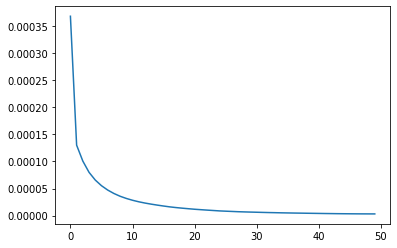

In [9]:
plt.plot(losses)
plt.show()

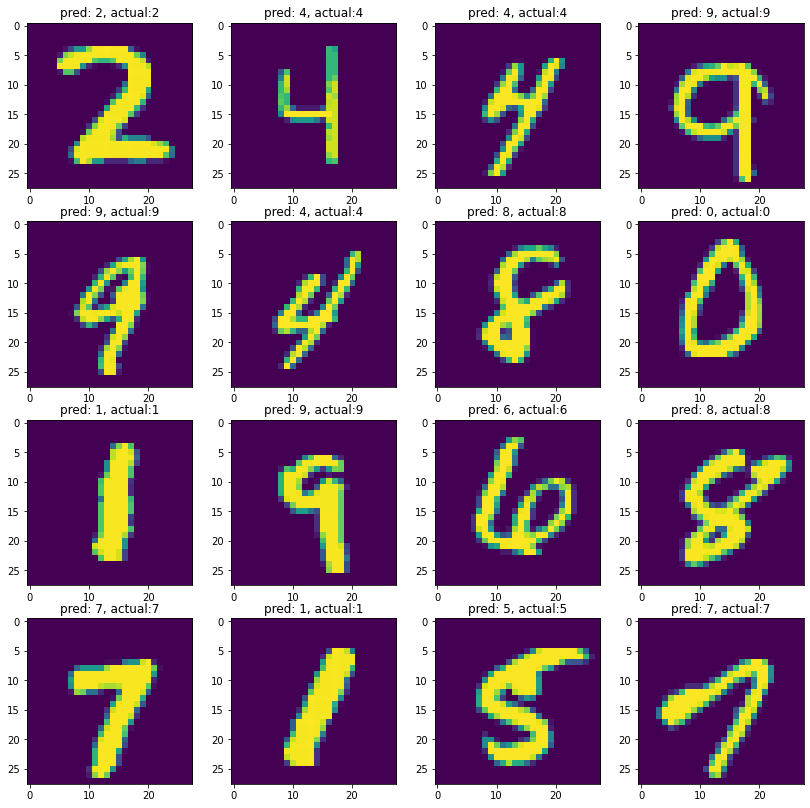

In [10]:
fig=plt.figure(figsize=(14,14))
col,rows=4,4
for i in range(1,col * rows + 1):
    j = random.randint(0,9999)
    pred = ml.forward(x_test[j].reshape(1, -1))
    fig.add_subplot(rows,col,i)
    plt.imshow(x_test[j].reshape(28,28))
    plt.title(f"pred: {np.argmax(pred)}, actual:{np.argmax(y_test[j])}")
plt.show()

In [11]:
wrong = 0
classes = dict()
for i in tqdm(range(len(x_test))):
    pred = ml.forward(x_test[i].reshape(1, -1))
    pred = pred.reshape(-1)
    if np.argmax(y_test[i]) != np.argmax(pred):
        wrong += 1
        if np.argmax(y_test[i]) in classes:
            classes[np.argmax(y_test[i])] += 1
        else:
            classes[np.argmax(y_test[i])] = 1
print(f"{round((wrong/len(x_test))*100, 2)}%, ", classes, wrong)

100%|██████████| 10000/10000 [00:12<00:00, 794.42it/s]

1.74%,  {9: 20, 5: 24, 8: 25, 1: 10, 6: 14, 0: 9, 7: 28, 4: 14, 2: 18, 3: 12} 174
